In [2]:
import numpy as onp

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams.update({"text.usetex": True})

# Theoretical Scaling

**NOTE**: All following computations assume ``newton on`` is used.

**Note**: We consider only the scaling ofr

For models with a fixed cutoff and systems with homogeneous density, the computational cost should scale linearly with the number of particles $C \propto N$.
## Scaling with the system size

For homogeneous systems, the number of particles scales with $N \propto L^3$, where $L$ is the side-length of the box.
Since additional ghost atoms are necessary to correctly encode the environment, the local box must be additionally enlarged by $2*L_\text{ghost}$, where $L_\text{ghost} = (M + 1)r_\text{cut}$ depends on the number of message passing steps $M$ and the cutoff $r_\text{cut}$.
Therefore, the effort of computing forces for a domain scales with
$$ C \propto (L + 2L_\text{ghost})^3 = (L + (2M + 2)r_\text{cut})^3$$

## Work spent on local atoms

The ratio of work spent on computing actual relevant interactions vs total work spend on all interactions is given by
$$ \epsilon = \frac{L^3}{(L + (2M + 2)r_\text{cut})^3}$$
The plot below shows the efficiencies for a cutoff of 0.5 nm.



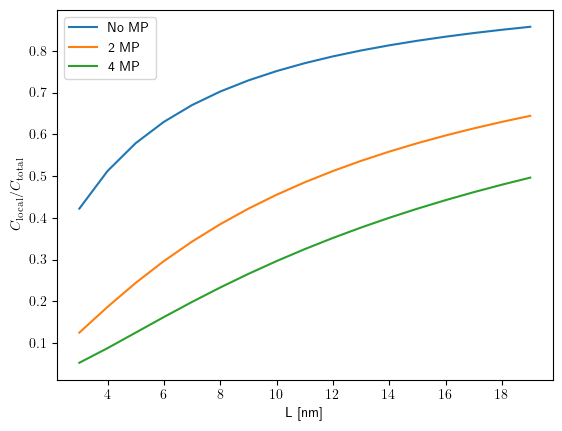

In [3]:
def compute_efficiency(L, M=1, r_cut=0.5):
    """Compute the efficiency of the local model."""
    L_ghost = (2 * M + 2) * r_cut
    return L**3 / (L + L_ghost)**3

L = onp.arange(3, 20)
plt.plot(L, compute_efficiency(L, M=0), label="No MP")
plt.plot(L, compute_efficiency(L, M=2), label="2 MP")
plt.plot(L, compute_efficiency(L, M=4), label="4 MP")

plt.xlabel("L [nm]")
plt.ylabel(r"$C_\mathrm{local} / C_\mathrm{total}$")

plt.legend()

## Strong Scaling

In a simplified view, the cost depends only on the number of particles processed by each device.
Additional costs, e.g., through communication, are not considered.

For simplicity, we also assume that the system can be divided into $D$ equally sized cubic domains.
This division is possible, e.g., for a cubic box and $D=1,8,27,64,125,\ldots$ GPUs.
Then, the local domain length scales with $L \propto D^{1/3}$.
Consequently, the runtime scales with
$$
R = \frac{(L / D^{1/3} + (2M + 2)r_\text{cut})^3}{(L + (2M + 2)r_\text{cut})^3}.
$$

Additionally, the cost, proportional to the number of particles, scales with
$$
C(D) = \frac{(L / D^{1/3} + (2M + 2)r_\text{cut})^3 D}{(L + (2M + 2)r_\text{cut})^3}
$$


Text(0, 0.5, 'Relative Cost')

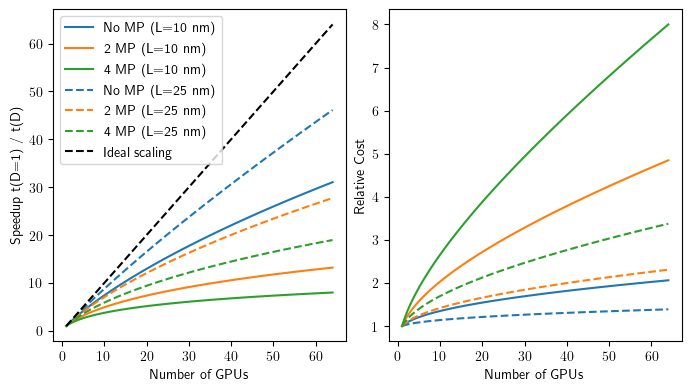

In [4]:
def compute_weak_scaling_runtime(D, L=10, M=0, r_cut=0.5):
    """Compute the weak scaling runtime."""
    L_ghost = (2 * M + 2) * r_cut
    return (L + L_ghost)**3 / (L / D**(1/3) + L_ghost)**3

def compute_weak_scaling_cost(D, L=10, M=0, r_cut=0.5):
    """Compute the weak scaling runtime."""
    L_ghost = (2 * M + 2) * r_cut
    return  (L / D**(1/3) + L_ghost)**3 * D / (L + L_ghost)**3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8, 3.8), layout="constrained", sharex='row')

D = onp.linspace(1, 64, 100)

colors = ["tab:blue", "tab:orange", "tab:green"]

ax1.plot(D, compute_weak_scaling_runtime(D, M=0), label="No MP (L=10 nm)", color=colors[0])
ax1.plot(D, compute_weak_scaling_runtime(D, M=2), label="2 MP (L=10 nm)", color=colors[1])
ax1.plot(D, compute_weak_scaling_runtime(D, M=4), label="4 MP (L=10 nm)", color=colors[2])

ax1.plot(D, compute_weak_scaling_runtime(D, M=0, L=25), "--", label="No MP (L=25 nm)", color=colors[0])
ax1.plot(D, compute_weak_scaling_runtime(D, M=2, L=25), "--", label="2 MP (L=25 nm)", color=colors[1])
ax1.plot(D, compute_weak_scaling_runtime(D, M=4, L=25), "--", label="4 MP (L=25 nm)", color=colors[2])

ax1.plot(D, D, "--", label="Ideal scaling", color="black")

ax1.set_xlabel("Number of GPUs")
ax1.set_ylabel("Speedup t(D=1) / t(D)")

ax1.legend()

ax2.plot(D, compute_weak_scaling_cost(D, M=0), label="No MP (L=10 nm)", color=colors[0])
ax2.plot(D, compute_weak_scaling_cost(D, M=2), label="2 MP (L=10 nm)", color=colors[1])
ax2.plot(D, compute_weak_scaling_cost(D, M=4), label="4 MP (L=10 nm)", color=colors[2])

ax2.plot(D, compute_weak_scaling_cost(D, M=0, L=25), "--", label="No MP (L=25 nm)", color=colors[0])
ax2.plot(D, compute_weak_scaling_cost(D, M=2, L=25), "--", label="2 MP (L=25 nm)", color=colors[1])
ax2.plot(D, compute_weak_scaling_cost(D, M=4, L=25), "--", label="4 MP (L=25 nm)", color=colors[2])

ax2.set_xlabel("Number of GPUs")
ax2.set_ylabel("Relative Cost")


## Weak Scaling

For weak scaling, the number of particles per device is kept constant while the number of devices is increased.
Factors that contribute to additional cost and runtime are:

* Cost through communication
    * Determined by LAMMPS, as we rely on the LAMMPS communication scheme
    * Can be influenced by settings such as the domain decomposition and the cluster infrastructure
* Cost through recompilation
    * Cost vs. recompilation time can be balanced by setting the buffer capacity multipliers $f$ for neighbor list and atom buffers.
    * Devices are encouraged to recompile simultaneously following the rule: If one device has to recompile, all other devices check their buffers in the next run. If the buffer capacity is diminishing, indicated by $N_\text{buff} > f^{-1/2} N_\text{max}$, the device recompiles.
    * After recompilation, the devices will collectively recompile if the buffer usage grows by $\sqrt{f}$ and **will always recompile** if the capacity grows by $f$ due to insufficient capacity.
    * Improved heuristics could be implemented if necessary.


## Cost of Different Models

Increasing the number of message passing steps $M$ increases the cost of the model.
However, using a model with fewer message passing steps may require a more expensive model (e.g., with larger cutoff) to achieve the same accuracy.
Assuming that the cost only scales linearly with the number of neighboring particles, therefore with $C\propto r_\text{cut}^3$, the cost of two models with different message passing steps and cutoffs can be computed via
$$
\frac{C(M_2, r_{\text{cut},2})}{C(M_1, r_{\text{cut},1})} = \frac{(L + (2M_2 + 2)r_{\text{cut},2})^3}{(L + (2M_1 + 2)r_{\text{cut},1})^3}
$$

Below, the cost ratios are plotted for a potential with two message passing steps vs. a non message passing model with increasing cutoffs but same features.

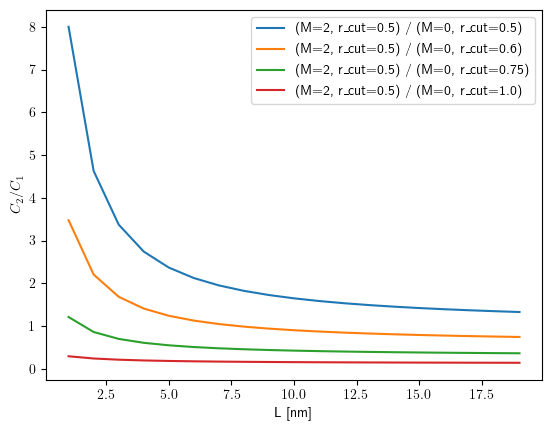

In [5]:
def compute_cost(L, M=1, r_cut=0.5):
    """Compute the efficiency of the local model."""
    L_ghost = (2 * M + 2) * r_cut
    return ((L + L_ghost) ** 3) * (r_cut ** 3)


L = onp.arange(1, 20)
plt.plot(L, compute_cost(L, M=2) / compute_cost(L, M=0), label="(M=2, r_cut=0.5) / (M=0, r_cut=0.5)")
plt.plot(L, compute_cost(L, M=2) / compute_cost(L, M=0, r_cut=0.6), label="(M=2, r_cut=0.5) / (M=0, r_cut=0.6)")
plt.plot(L, compute_cost(L, M=2) / compute_cost(L, M=0, r_cut=0.75), label="(M=2, r_cut=0.5) / (M=0, r_cut=0.75)")
plt.plot(L, compute_cost(L, M=2) / compute_cost(L, M=0, r_cut=1.0), label="(M=2, r_cut=0.5) / (M=0, r_cut=1.0)")

plt.xlabel("L [nm]")
plt.ylabel(r"$C_2 / C_1$")

plt.legend()

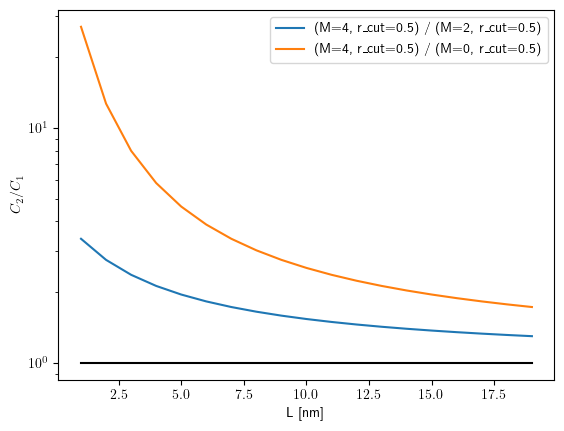

In [6]:
def compute_cost(L, M=1, r_cut=0.5):
    """Compute the efficiency of the local model."""
    L_ghost = (2 * M + 2) * r_cut
    return ((L + L_ghost) ** 3) * (r_cut ** 3)


L = onp.arange(1, 20)
plt.semilogy(L, compute_cost(L, M=4) / compute_cost(L, M=2), label="(M=4, r_cut=0.5) / (M=2, r_cut=0.5)")
plt.semilogy(L, compute_cost(L, M=4) / compute_cost(L, M=0), label="(M=4, r_cut=0.5) / (M=0, r_cut=0.5)")
plt.semilogy(L, onp.ones_like(L), color="k")

plt.xlabel("L [nm]")
plt.ylabel(r"$C_2 / C_1$")

plt.legend()

The plot below shows the cost ratio for message passing in the asymptotic limit of $L \to 0$.

Text(0, 0.5, 'Asymptotic Cost Ratio')

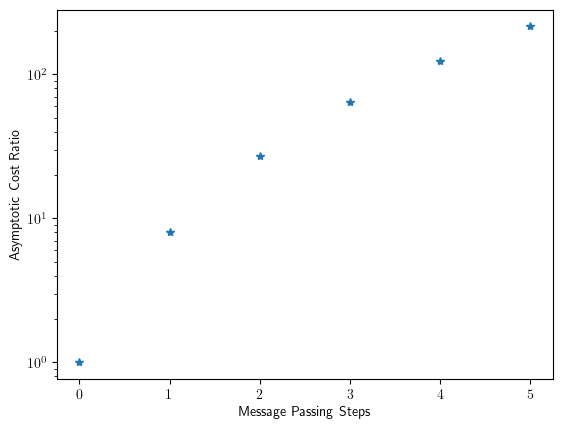

In [7]:
MP = onp.arange(0, 6)
plt.semilogy(MP, (2 + 2*MP)**3 / (2 + 2*0)**3, "*")

plt.xlabel("Message Passing Steps")
plt.ylabel("Asymptotic Cost Ratio")

# Limitations

The table below shows maximum numbers of atoms on a *A100* GPU for the different models.

| System | Allegro      | MACE          | PaiNN         |
|--------|--------------|---------------|---------------|
|Aluminum| 600k / 11 nm | 190k / 7.3 nm | 100k / 6.1 nm |
|Peptide | 50k / 8 nm   | 100k / 10 nm  | 32k / 7 nm    |
|Liquid-vapor| 200k / 13.6 nm | 100k / 10.8 nm | 33k / 7.4nm |

The table below shows the computional cost for each simulation step on a *A100* GPU for the different models. (timestep / second)
| System | Allegro      | MACE          | PaiNN         |
|--------|--------------|---------------|---------------|
|Aluminum|  1.189 | 0.837 | 2.431 |
|Peptide | 1.185   | 0.964  | 2.155    |
|Liquid-vapor| 0.883 | 1.015 | 2.687 |


Text(0, 0.5, 'Relative Cost')

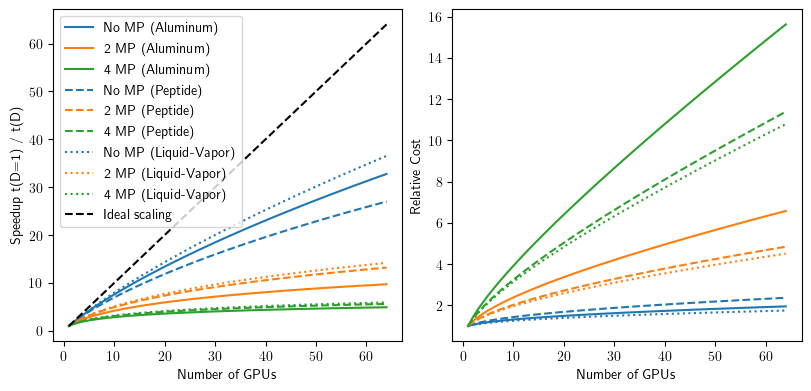

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.0, 3.8), layout="constrained", sharex='row')

D = onp.linspace(1, 64, 100)

colors = ["tab:blue", "tab:orange", "tab:green"]

ax1.plot(D, compute_weak_scaling_runtime(D, M=0, L=11), label="No MP (Aluminum)", color=colors[0])
ax1.plot(D, compute_weak_scaling_runtime(D, M=2, L=7.3), label="2 MP (Aluminum)", color=colors[1])
ax1.plot(D, compute_weak_scaling_runtime(D, M=4, L=6.1), label="4 MP (Aluminum)", color=colors[2])

ax1.plot(D, compute_weak_scaling_runtime(D, M=0, L=8), "--", label="No MP (Peptide)", color=colors[0])
ax1.plot(D, compute_weak_scaling_runtime(D, M=2, L=10), "--", label="2 MP (Peptide)", color=colors[1])
ax1.plot(D, compute_weak_scaling_runtime(D, M=4, L=7), "--", label="4 MP (Peptide)", color=colors[2])

ax1.plot(D, compute_weak_scaling_runtime(D, M=0, L=13.6), ":", label="No MP (Liquid-Vapor)", color=colors[0])
ax1.plot(D, compute_weak_scaling_runtime(D, M=2, L=10.8), ":", label="2 MP (Liquid-Vapor)", color=colors[1])
ax1.plot(D, compute_weak_scaling_runtime(D, M=4, L=7.4), ":", label="4 MP (Liquid-Vapor)", color=colors[2])

ax1.plot(D, D, "--", label="Ideal scaling", color="black")

ax1.set_xlabel("Number of GPUs")
ax1.set_ylabel("Speedup t(D=1) / t(D)")

ax1.legend()

ax2.plot(D, compute_weak_scaling_cost(D, M=0, L=11), label="No MP (Aluminum)", color=colors[0])
ax2.plot(D, compute_weak_scaling_cost(D, M=2, L=7.3), label="2 MP (Aluminum)", color=colors[1])
ax2.plot(D, compute_weak_scaling_cost(D, M=4, L=6-1), label="4 MP (Aluminum)", color=colors[2])

ax2.plot(D, compute_weak_scaling_cost(D, M=0, L=8), "--", label="No MP (Peptide)", color=colors[0])
ax2.plot(D, compute_weak_scaling_cost(D, M=2, L=10), "--", label="2 MP (Peptide)", color=colors[1])
ax2.plot(D, compute_weak_scaling_cost(D, M=4, L=7), "--", label="4 MP (Peptide)", color=colors[2])

ax2.plot(D, compute_weak_scaling_cost(D, M=0, L=13.6), ":", label="No MP (Liquid-Vapor)", color=colors[0])
ax2.plot(D, compute_weak_scaling_cost(D, M=2, L=10.8), ":", label="2 MP (Liquid-Vapor)", color=colors[1])
ax2.plot(D, compute_weak_scaling_cost(D, M=4, L=7.4), ":", label="4 MP (Liquid-Vapor)", color=colors[2])

ax2.set_xlabel("Number of GPUs")
ax2.set_ylabel("Relative Cost")